# Submitting to IMC 2021 with custom matcher
> "And COLMAP"
- toc: false
- image: images/wooden_lady.png
- branch: master
- badges: true
- comments: true
- hide: false
- search_exclude: false

## Intro

In the [previous tutorial](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/12/submitting-to-IMC2021-step-by-step.html) we have created a pipeline for submitting to the IMC2021. 
However, we have not covered all the possibilities. First, we haven't submissted custom matches, instead we just run a standard Lowe SNN test with cross-check. Second, we haven't evaluate multiview (COLMAP) part.
In this tutorial we will do both. 
I am assuming that you have completed the [previous part](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/12/submitting-to-IMC2021-step-by-step.html). If not, please do, because we will be relying on the already extracted features. Let's check if the feature are there


```bash
cd imc2021-sample-kornia-submission
ls extracted/cv2-dog-affnet-hardnet8/googleurban/edinburgh/
```

```
angles.h5  descriptors.h5  keypoints.h5  scales.h5  scores.h5
```

> Warning: There is a subtle problem with previous tutorial, so we cannot use pre-extracted features.

Specifically, because OpenCV SIFT does not exactly respect max_features parameter and can sometimes output 8002 features, instead of 8000. When we were importing the features alone, benchmark `import_features.py` script automatically re-sorted features based on the score and clip the extra 1-3 features. However, this functionality is not available for the importing custom matches. I have already corrected [previous post](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/12/submitting-to-IMC2021-step-by-step.html), so you can use it for the re-extration. Or, if you are reading this whole tutorial after May 24, just ignore this.

Now we will install [AdaLAM](https://arxiv.org/abs/2006.04250) - [one of the winners of IMC2020 Challenge](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/14/IMC2020-competition-recap.html). It uses keypoint geometry to filter out unreliable matches.

```bash
pip install git+https://github.com/cavalli1234/AdaLAM.git
```

Let's check if it works on the sample image pair. We will read the pre-extracted features for it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch
import kornia as K
import kornia.feature as KF
import h5py
import json
from PIL import Image
from adalam import AdalamFilter
from kornia_moons.feature import *

def load_h5(filename):
    '''Loads dictionary from hdf5 file'''

    dict_to_load = {}
    try:
        with h5py.File(filename, 'r') as f:
            keys = [key for key in f.keys()]
            for key in keys:
                dict_to_load[key] = f[key][()]
    except:
        print('Cannot find file {}'.format(filename))
    return dict_to_load

PATH_TO_FEATS = 'extracted/cv2-dog-affnet-hardnet8/googleurban/edinburgh/'
kps = load_h5(os.path.join(PATH_TO_FEATS, 'keypoints.h5'))
angles = load_h5(os.path.join(PATH_TO_FEATS, 'angles.h5'))
scales = load_h5(os.path.join(PATH_TO_FEATS, 'scales.h5'))
descs = load_h5(os.path.join(PATH_TO_FEATS, 'descriptors.h5'))


I have selected two images, which are matching:

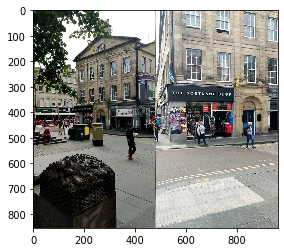

In [2]:
IMG_DIR = '../imc-2021-data/googleurban/edinburgh/set_100/images/'
img1_key = '2b5315968bc5468c995b978620879439'
img2_key = '6264aee21d1b48b7985901c4bedfdbd4'

img1 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img1_key}.png')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img2_key}.png')), cv2.COLOR_BGR2RGB)
plt.imshow(np.concatenate([img1, img2], axis=1))

We will start with matching and drawing the matches with OpenCV for sanity check.

<Figure size 432x288 with 0 Axes>

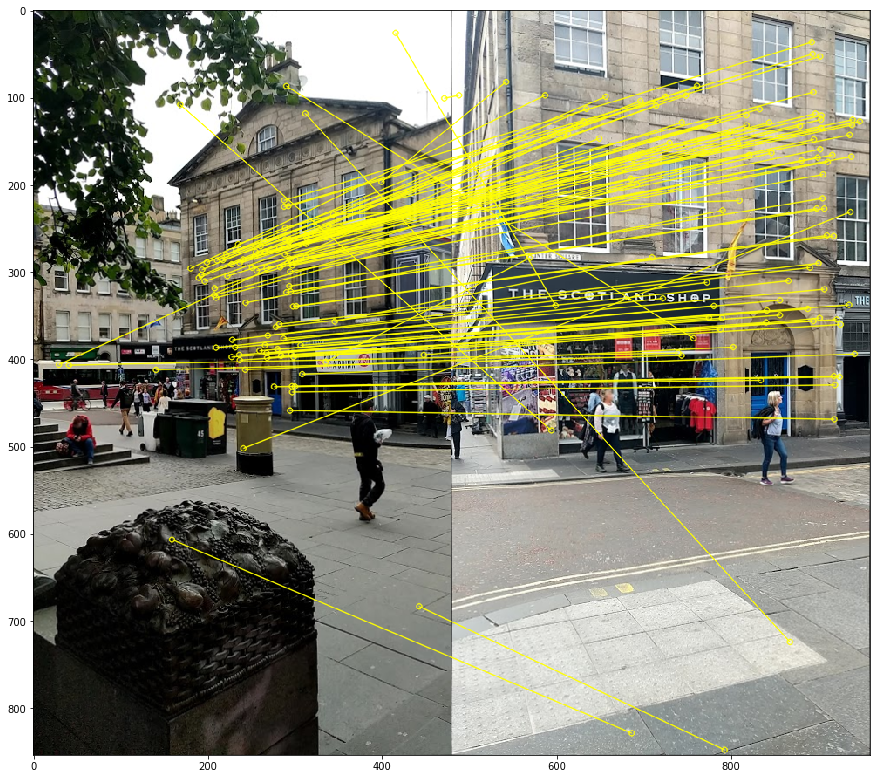

In [3]:
def opencv_from_imc(kps, sizes, angles):
    return [cv2.KeyPoint(kp[0], kp[1], float(s), float(a)) for  kp, s, a in zip(kps, sizes, angles)]

def get_data(kps, angles, scales, descs, img_key):
    kp1 = kps[img_key]
    s1 = scales[img_key]
    a1 = angles[img_key]
    descs1 = descs[img_key]
    return kp1, s1, a1, descs1
 
def match(img1_key, img2_key, kps, angles, scales, descs):
    kp1, s1, a1, descs1 = get_data(kps, angles, scales, descs, img1_key)
    kp2, s2, a2, descs2 = get_data(kps, angles, scales, descs, img2_key)
    dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.9)
    return dists, idxs

def draw_matches(img1_key, img2_key, dists, idxs, kps, angles, scales, descs):
    tentatives = cv2_matches_from_kornia(dists, idxs)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = [True for x in idxs], # draw only inliers
                   flags = 2)
    img1 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img1_key}.png')), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img2_key}.png')), cv2.COLOR_BGR2RGB)
    kp1, s1, a1, _ = get_data(kps, angles, scales, descs, img1_key)
    kp2, s2, a2, descs2 = get_data(kps, angles, scales, descs, img2_key)
    
    img_out = cv2.drawMatches(img1,opencv_from_imc(kp1, s1, a1),
                              img2,opencv_from_imc(kp2, s2, a2),
                              tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    return

dists, idxs = match(img1_key, img2_key, kps, angles, scales, descs)
draw_matches(img1_key, img2_key, dists, idxs,  kps, angles, scales, descs)

Everything seems to be working quite well. But, as you can see, we have some wrong matches among tentatives. 
Let's try AdaLAM

<Figure size 432x288 with 0 Axes>

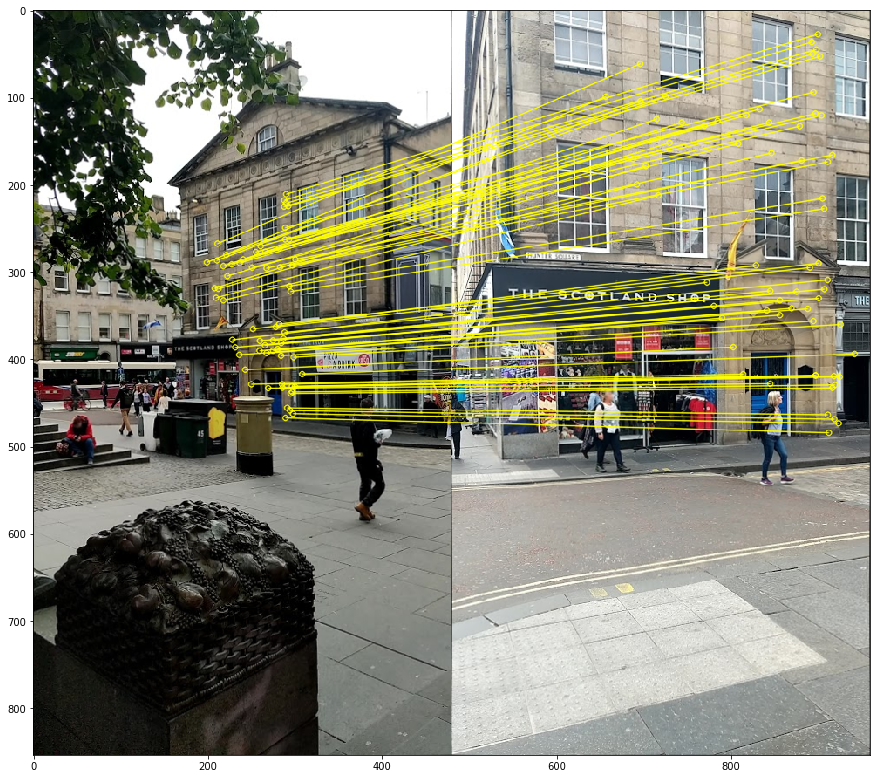

In [4]:
def match_adalam(img1_key, img2_key, kps, angles, scales, descs):
    kp1, s1, a1, descs1 = get_data(kps, angles, scales, descs, img1_key)
    kp2, s2, a2, descs2 = get_data(kps, angles, scales, descs, img2_key)
    matcher = AdalamFilter()
    
    # AdaLAM wants image sizes, so we have to read them.
    img1 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img1_key}.png')), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img2_key}.png')), cv2.COLOR_BGR2RGB)

    idxs = matcher.match_and_filter(kp1, kp2,
                            descs1, descs2,
                            im1shape=img1.shape[:2], 
                            im2shape=img2.shape[:2],
                            o1=a1.reshape(-1),
                            o2=a2.reshape(-1),
                            s1=s1.reshape(-1),
                            s2=s2.reshape(-1))
    # AdaLAM does not provide confidence score, so we will create dummy one
    dists = torch.ones_like(idxs)[:,0] 
    return dists, idxs
dists, idxs = match_adalam(img1_key, img2_key, kps, angles, scales, descs)
draw_matches(img1_key, img2_key, dists, idxs,  kps, angles, scales, descs)


We have significantly more matches, which are also cleaner, although not ideal. There is one more thing: if we are going to submit custom matches, we have to run RANSAC ourself (if needed), here is a quote from the [competition rules](https://www.cs.ubc.ca/research/image-matching-challenge/2021/submit/):

```
The "geom"/"method" field must be set to "cv2-8pt" if custom matches are enabled, as we assume you tune and run your favourite RANSAC algorithm, if applicable.
```

Thus, we need to merge RANSAC (we pick inlier threshold from the previous tutorial) and matching:

<Figure size 432x288 with 0 Axes>

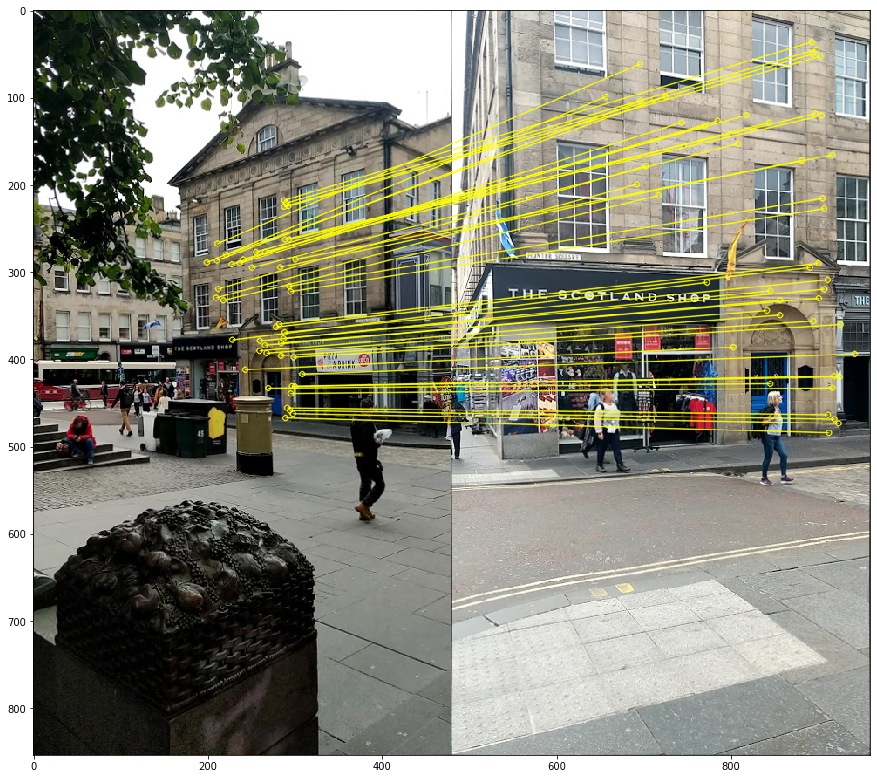

In [6]:
import pydegensac

def match_adalam_with_degensac(img1_key, img2_key, kps, angles, scales, descs, ds_name='phototourism'):
    kp1, s1, a1, descs1 = get_data(kps, angles, scales, descs, img1_key)
    kp2, s2, a2, descs2 = get_data(kps, angles, scales, descs, img2_key)
    matcher = AdalamFilter()
    
    # AdaLAM wants image sizes, so we have to read them.
    img1 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img1_key}.png')), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, f'{img2_key}.png')), cv2.COLOR_BGR2RGB)

    idxs = matcher.match_and_filter(kp1, kp2,
                            descs1, descs2,
                            im1shape=img1.shape[:2], 
                            im2shape=img2.shape[:2],
                            o1=a1.reshape(-1),
                            o2=a2.reshape(-1),
                            s1=s1.reshape(-1),
                            s2=s2.reshape(-1)).detach().cpu().numpy()
    src_pts = kp1[idxs[:,0]]
    dst_pts = kp2[idxs[:,1]]
    
    max_iters = 100000
    if ds_name.lower() == 'phototourism':
        inl_th = 0.5
    elif ds_name.lower() == 'pragueparks':
        inl_th = 1.5 
    elif ds_name.lower() == 'googleurban':
        inl_th = 0.75
    else:
        raise ValueError('Unknown dataset')
    F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, inl_th, 0.999999, max_iters)
    out_idxs = idxs[inliers_mask]
    # AdaLAM does not provide confidence score, so we will create dummy one
    dists = np.ones_like(out_idxs)[:,0] 
    return dists, out_idxs

dists, idxs = match_adalam_with_degensac(img1_key, img2_key, kps, angles, scales, descs)
draw_matches(img1_key, img2_key, dists, idxs,  kps, angles, scales, descs)


The last, but not least: we have to transpose output indexes, as benchmark expects them in the shape `[2 x B]`. Do not ask why :)

So, we are ready to process and save our matches. I have a bit optimized the loading process, but not much. Do not expect blazing speed :)
The full script is accesible [here](https://github.com/ducha-aiki/imc2021-sample-kornia-submission/blob/master/extract_adalam_degensac_matches.py). 

In [ ]:
import os
import h5py
from tqdm import tqdm
from PIL import Image

def match_adalam_with_degensac(kp1, kp2, s1, s2, a1, a2, descs1, descs2,
                               h1, w1, h2, w2, ds_name='phototourism'):
    matcher = AdalamFilter()
    
    idxs = matcher.match_and_filter(kp1, kp2,
                            descs1, descs2,
                            im1shape=(h1,w1), 
                            im2shape=(h2,w2),
                            o1=a1.reshape(-1),
                            o2=a2.reshape(-1),
                            s1=s1.reshape(-1),
                            s2=s2.reshape(-1)).detach().cpu().numpy()
    if len(idxs) < 7:
        return np.empty((0,1), dtype=np.float32), np.empty((0,2), dtype=np.int32)
    src_pts = kp1[idxs[:,0]]
    dst_pts = kp2[idxs[:,1]]
    
    max_iters = 100000
    if ds_name.lower() == 'phototourism':
        inl_th = 0.5
    elif ds_name.lower() == 'pragueparks':
        inl_th = 1.5 
    elif ds_name.lower() == 'googleurban':
        inl_th = 0.75
    else:
        raise ValueError('Unknown dataset')
    F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, inl_th, 0.999999, max_iters)
    out_idxs = idxs[inliers_mask]
    # AdaLAM does not provide confidence score, so we will create dummy one
    dists = np.ones_like(out_idxs)[:,0] 
    return dists, out_idxs


INPUT_DIR = '../imc-2021-data'
OUT_DIR = 'extracted/cv2-dog-affnet-hardnet8'

os.makedirs(OUT_DIR, exist_ok=True)
datasets = os.listdir(INPUT_DIR)
datasets = ['googleurban']
for ds in datasets:
    ds_in_path = os.path.join(INPUT_DIR, ds)
    ds_out_path = os.path.join(OUT_DIR, ds)
    os.makedirs(ds_out_path, exist_ok=True)
    seqs = os.listdir(ds_in_path)
    for seq in seqs:
        if os.path.isdir(os.path.join(ds_in_path, seq, 'set_100')):
            seq_in_path = os.path.join(ds_in_path, seq, 'set_100', 'images')
        else:
            seq_in_path = os.path.join(ds_in_path, seq)
        seq_out_path = os.path.join(ds_out_path, seq)
        kps = load_h5(os.path.join(seq_out_path, 'keypoints.h5'))
        angles = load_h5(os.path.join(seq_out_path, 'angles.h5'))
        scales = load_h5(os.path.join(seq_out_path, 'scales.h5'))
        descs = load_h5(os.path.join(seq_out_path, 'descriptors.h5'))
        img_fnames = sorted(os.listdir(seq_in_path))[::-1]
        num_matches = []
        with h5py.File(f'{seq_out_path}/matches_stereo_0.h5', 'w') as f_m:
            for i1, img1_fname in tqdm(enumerate(img_fnames)):
                img1_key = os.path.splitext(os.path.basename(img1_fname))[0]
                img1_fname_full = os.path.join(seq_in_path, img1_fname)
                img1 = Image.open(img1_fname_full)
                w1, h1 = img1.size
                kp1, s1, a1, descs1 = get_data(kps, angles, scales, descs, img1_key)
                for img2_fname in img_fnames[i1+1:]:
                    img2_key = os.path.splitext(os.path.basename(img2_fname))[0]
                    img2_fname_full = os.path.join(seq_in_path, img2_fname)
                    img2 = Image.open(img2_fname_full)
                    w2, h2 = img2.size
                    match_key = f'{img1_key}-{img2_key}'
                    kp2, s2, a2, descs2 = get_data(kps, angles, scales, descs, img2_key)
                    _, idxs = match_adalam_with_degensac(kp1, kp2, s1, s2, a1, a2, descs1, descs2,
                                   h1, w1, h2, w2, ds_name=ds)
                    num_matches.append(len(idxs))
                    if len(idxs) == 0:
                        idxs = np.empty([0, 2], dtype=np.int32)
                    idxs = idxs.T
                    assert idxs.shape[0] == 2
                    f_m[match_key] = idxs
            print(f'Finished processing "{ds}/{seq}" -> {np.array(num_matches).mean()} matches/image')
        #We can use a single match file for multiview and stereo, but let's pretend that we have different ones
        copyfile(f'{seq_out_path}/matches_stereo_0.h5', f'{seq_out_path}/matches_multiview.h5')

Matching will take us couple of hours on GPU.



## Creating config json file

In addition to features and matches, we should submit a config file, which tells the benchmark, how the features should be matched and which RANSAC (no options, only `cv2-8pt` for using custom matches) we prefer.
So, we will create two config files - one, which standard matcher and second one, which uses AdaLAM.

First part of the config is `metadata` -- information about the method and authors.
If your method is under review, you may want to set flag `publish_anonymously` to `True`.

In [1]:
metadata_dict =  {
    "publish_anonymously": False,
    "authors": "Dmytro Mishkin, Milan Pultar and kornia team",
    "contact_email": "ducha.aiki@gmail.com",
    "method_name": "CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC",
    "method_description": 
    r"""OpeCV SIFT keypoints 8000 features, followed by the AffNet normalization 
    and HardNet8 descriptor as implemented in kornia.
    Matched using AdaLAM with DEGENSAC""",
    "link_to_website": "https://github.com/kornia/kornia",
    "link_to_pdf": "https://arxiv.org/abs/2007.09699"
}

Second part is `config_common`: it tells the benchmark, which keypoints and descriptors you use. 
We will also need this names when importing our features during tuning on the validation set.

In [2]:
config_common_dict =  {"json_label": "dog-affnet-hardnet8-degensac-adalam",
    "keypoint": "cv2dog",
    "descriptor": "affnethardnet8",
    "num_keypoints": 8000}

Finally, we have to specify robust geometry estimation method. We have no other choice than `cv2-8pt`, as pre-filtering with DEGENSAC is already performed.

In [3]:
from copy import deepcopy


geom_template_dict =  {"method": "cv2-8pt"
            }

Let's assemble and save our base config.

In [4]:
import json

base_config =  {
    "metadata": metadata_dict,
    "config_common": config_common_dict,
    "config_phototourism_stereo": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "geom": deepcopy(geom_template_dict)
        },
    "config_phototourism_multiview": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "colmap": {}},
    
    "config_pragueparks_stereo": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "geom": deepcopy(geom_template_dict)
        },
    "config_pragueparks_multiview": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "colmap": {}},
    "config_googleurban_stereo": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "geom": deepcopy(geom_template_dict)
        },
    "config_googleurban_multiview": {
        "use_custom_matches": True,
        "custom_matches_name": "adalam",
        "colmap": {}}
}


Finally, benchmark expects multiple configs, so we have to create a list, and then we can save our config

In [5]:
import json 

with open('base_config_adalam.json', 'w') as f:
    json.dump([base_config], f, indent=2)

# Preliminary evaluation

Now let's check how our features perform on validation set. We have to import our feature to the benchmark and run the benchmark.

I will cheat a little bit here and skip the multiview evaluation. The reason is that it requires [colmap](https://colmap.github.io), which might be not easy to install. 

### Importing features

Here we have to provide the same `keypoint` and `descriptor` names, as we wrote in json config. 
The rest of arguments are straightforward: path to features, json, etc.


```bash
cd ../image-matching-benchmark/
python -utt import_features.py --kp_name cv2dog --desc_name affnethardnet8 --num_keypoints 8000 --path_features ../imc2021-sample-kornia-submission/extracted/cv2-dog-affnet-hardnet8  --path_results ../benchmark-results --subset both  --is_challenge false --path_json ../imc2021-sample-kornia-submission/base_config_adalam.json  --datasets phototourism googleurban  --match_name adalam
```

### Running the evaluation

Now we are ready to run the evaluation. Note, that now we are running multiview evaluation as well. So, let us check if colmap is available. 

```bash
colmap --help
```
The output should be something like that:

    COLMAP 3.6 -- Structure-from-Motion and Multi-View Stereo
              (Commit Unknown on Unknown with CUDA)
              
OK, now time to run the evaluation

```bash
python -utt run.py --run_mode=interactive --json_method=../imc2021-sample-kornia-submission/base_config_adalam.json --subset=val  --path_data ../imc-2021-data/ --path_results ../benchmark-results --is_challenge false
```

After a while (an **6 hours** for 32 cores machine), the process will finish and you will see the following log message:

```
 -- Saving to: "packed-val/dog-affnet-hardnet8-degensac-adalam.json"
```

To compare with results without AdaLAM, let's also run multiview evaluation for the previous setup. I did not do that, because of the time it takes.

```bash

```bash
python -utt run.py --run_mode=interactive --json_method=../imc2021-sample-kornia-submission/base_config.json --subset=val  --path_data ../imc-2021-data/ --path_results ../benchmark-results --is_challenge false
```


### Reading results

Json file with evaluation results are saved to `image-matching-benchmark/packed-val/dog-affnet-hardnet8-degensac.json` and `image-matching-benchmark/packed-val/dog-affnet-hardnet8-degensac-adalam.json` , and some visualizations -- to `../benchmark-visualization/png`.

First, we come back to our `imc2021-sample-kornia-submission` directory:

```bash
cd ../imc2021-sample-kornia-submission
```

Metric, which are used for the competition is mean average accuracy (mAA) at visibility threshold 0.1

{'mean': 0.0, 'std_scenes': 0.0, 'std_runs': 0.0}

In [15]:
import os

hashname='dog-affnet-hardnet8-degensac'
res_fname = os.path.join('../image-matching-benchmark/packed-val', f'{hashname}.json')

with open(res_fname, 'r') as f:
    results = json.load(f)

submission_name = results['config']['metadata']['method_name']
datasets = ['phototourism', 'pragueparks', 'googleurban']
tasks = ['stereo', 'multiview'] 
metric = 'qt_auc_10_th_0.1'

for dset in datasets:
    mAA_stereo = results[dset]['results']['allseq']['stereo']['run_avg'][metric]['mean']
    mAA_colmap = results[dset]['results']['allseq']['multiview']['run_avg']['bag_avg']['qt_auc_colmap_10']['mean']
    print (f'{submission_name} stereo mAA for {dset} is {mAA_stereo:.4f}')
    print (f'{submission_name} multiview mAA for {dset} is {mAA_colmap:.4f}')
    # Remember, I did not run multiview evaluation for the original submission.

CV-DoG-AffNet-HardNet8 (kornia) stereo mAA for phototourism is 0.7108
CV-DoG-AffNet-HardNet8 (kornia) multiview mAA for phototourism is 0.0000
CV-DoG-AffNet-HardNet8 (kornia) stereo mAA for pragueparks is 0.5850
CV-DoG-AffNet-HardNet8 (kornia) multiview mAA for pragueparks is 0.0000
CV-DoG-AffNet-HardNet8 (kornia) stereo mAA for googleurban is 0.3099
CV-DoG-AffNet-HardNet8 (kornia) multiview mAA for googleurban is 0.0000


In [16]:
import os

hashname='dog-affnet-hardnet8-degensac-adalam'
res_fname = os.path.join('../image-matching-benchmark/packed-val', f'{hashname}.json')

with open(res_fname, 'r') as f:
    results_adalam = json.load(f)

submission_name_adalam = results_adalam['config']['metadata']['method_name']
datasets = ['phototourism', 'pragueparks', 'googleurban']
tasks = ['stereo'] # ['stereo', 'multiview']  #Remember, that we skip colmap evaluations
metric = 'qt_auc_10_th_0.1'
for dset in datasets:
    mAA_stereo = results_adalam[dset]['results']['allseq']['stereo']['run_avg'][metric]['mean']
    mAA_colmap = results_adalam[dset]['results']['allseq']['multiview']['run_avg']['bag_avg']['qt_auc_colmap_10']['mean']
    print (f'{submission_name_adalam} stereo mAA for {dset} is {mAA_stereo:.4f}')
    print (f'{submission_name_adalam} multiview mAA for {dset} is {mAA_colmap:.4f}')

CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC stereo mAA for phototourism is 0.7326
CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC multiview mAA for phototourism is 0.8566
CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC stereo mAA for pragueparks is 0.6624
CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC multiview mAA for pragueparks is 0.5584
CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC stereo mAA for googleurban is 0.3310
CV-DoG-AffNet-HardNet8-AdaLAM-DEGENSAC multiview mAA for googleurban is 0.1597


We can also see results sequence-by-sequence

Text(0.5, 0, 'Sequence')

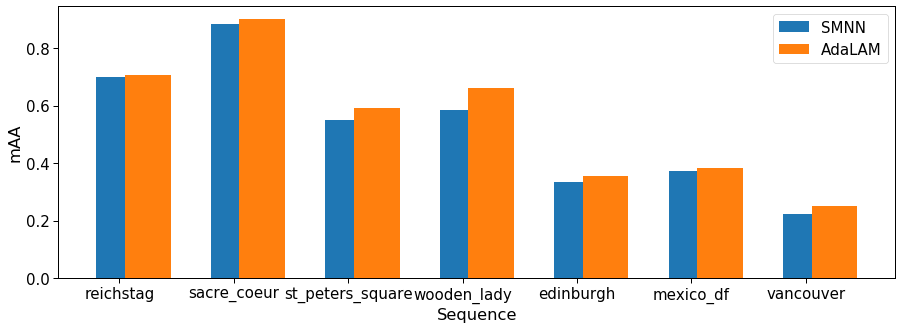

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_context('paper', font_scale=1.7)
seqs = []
mAAs_adalam = []
mAAs = []

for dset in datasets:
    for task in tasks:
        for seq in results[dset]['results'].keys():
            if seq == 'allseq': 
                continue
            mAA  = results[dset]['results'][seq][task]['run_avg'][metric]['mean']
            mAA_adalam  = results_adalam[dset]['results'][seq][task]['run_avg'][metric]['mean']
            
            mAAs.append(mAA)
            mAAs_adalam.append(mAA_adalam)
            
            seqs.append(seq)
fig, ax = plt.subplots(figsize=(15,5))
xticks = 2*np.arange(len(seqs))
ax.set_xticks(xticks)
ax.bar(xticks, mAAs)
ax.bar(xticks+0.5, mAAs_adalam)
ax.set_xticklabels(seqs)
ax.legend(['SMNN', 'AdaLAM'])
ax.set_ylabel('mAA')
ax.set_xlabel('Sequence')

How do our feature correspondences look like?

## Creating final submission
Its time to create our final submission!

In [25]:

configs = []
current_config = deepcopy(base_config)

    
current_config['metadata']['method_name'] = 'KORNIA TUTORIAL AdaLAM CV-DoG-AffNet-HardNet8'

label = current_config['config_common']['json_label'] 
current_config['config_common']['json_label']  = f'{label}'
configs.append(current_config)

print (current_config)
with open('final_submission_adalam.json', 'w') as f:
    json.dump(configs, f, indent=2)

{'metadata': {'publish_anonymously': False, 'authors': 'Dmytro Mishkin, Milan Pultar and kornia team', 'contact_email': 'ducha.aiki@gmail.com', 'method_name': 'KORNIA TUTORIAL AdaLAM CV-DoG-AffNet-HardNet8', 'method_description': 'OpeCV SIFT keypoints 8000 features, followed by the AffNet normalization \n    and HardNet8 descriptor as implemented in kornia.\n    Matched using AdaLAM with DEGENSAC', 'link_to_website': 'https://github.com/kornia/kornia', 'link_to_pdf': 'https://arxiv.org/abs/2007.09699'}, 'config_common': {'json_label': 'dog-affnet-hardnet8-degensac-adalam', 'keypoint': 'cv2dog', 'descriptor': 'affnethardnet8', 'num_keypoints': 8000}, 'config_phototourism_stereo': {'use_custom_matches': True, 'custom_matches_name': 'adalam', 'geom': {'method': 'cv2-8pt'}}, 'config_phototourism_multiview': {'use_custom_matches': True, 'custom_matches_name': 'adalam', 'colmap': {}}, 'config_pragueparks_stereo': {'use_custom_matches': True, 'custom_matches_name': 'adalam', 'geom': {'method'

```
Submission Zip file should have folder structure as follow:
 ├── config.json
 ├── [Dataset 1]
 │   ├── [Sequence 1]
 │   │   ├── keypoints.h5
 │   │   ├── descriptors.h5
 │   │   ├── matches.h5
 │   ├── [Sequence 2]
 │   │   ├── ...
 ├── [Dataset 2]
 │   ├── ...
```

So we have to just copy our features, add config and zip them.

```bash
cp final_submission_adalam.json extracted/cv2-dog-affnet-hardnet8/config.json
cd extracted/cv2-dog-affnet-hardnet8
zip -r submission.zip *
```

Last step before the submission - check the submission for correctness with provided script

```bash
cd ../../../image-matching-benchmark
python -utt submission_validator.py --submit_file_path ../imc2021-sample-kornia-submission/extracted/cv2-dog-affnet-hardnet8/submission.zip --benchmark_repo_path . --raw_data_path ../imc-2021-data/ --datasets googleurban phototourism pragueparks
```

If everything is correct, you will see:

```
Validating method 1/1: "dog-affnet-hardnet8-degensac"
['googleurban', 'phototourism', 'pragueparks']
Running: googleurban, stereo track
Running: googleurban, multiview track
Running: phototourism, stereo track
Running: phototourism, multiview track
Running: pragueparks, stereo track
Running: pragueparks, multiview track
Validating key "config_googleurban_stereo"
Validating key "config_googleurban_multiview"
Validating key "config_phototourism_stereo"
Validating key "config_phototourism_multiview"
Validating key "config_pragueparks_stereo"
Validating key "config_pragueparks_multiview"
```

And file `submission_log.txt` will appear near our .zip file.

```bash
cat ../imc2021-sample-kornia-submission/extracted/cv2-dog-affnet-hardnet8/submission_log.txt
```

```
Submission is in proper format, please submit to IMW 2021 website.
```
That's all, folks! We can submit! But, please, do not just submit this sample submission - make your own :)